# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [1]:
import os
import time

# wait_to_make = "trained_list/mpnet-base-trans.txt"
# count = 0
# while 1:
#     if os.path.exists(wait_to_make):
#         break
#     print(f'sleep {count} h')
#     time.sleep(3600)
#     count+=1
    


In [2]:
_mixout = 0.9
EXP_NAME = f"microsoft-deberta-v3-base-mixout{_mixout}-transformer-all"


In [3]:
# !nvidia-smi
! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [4]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================

import os
import datetime

INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'
dt_now = datetime.datetime.now()

date = dt_now.strftime('%Y-%m-%d-%H-%M-%S')
 
OUTPUT_DIR = f'./output/{EXP_NAME}/'
# if not os.path.exists(OUTPUT_DIR):
os.makedirs(OUTPUT_DIR, exist_ok=True)


# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    # model="microsoft/deberta-v3-large"
    model = "microsoft/deberta-v3-base"
    # size = "large
    # model = f"{model}-{size}"
    if "small" in model:
        hidden_state = hiddden_state_fix = 512
    elif "base" in model:
        hidden_state = hiddden_state_fix = 768
    elif "large" in model:
        hidden_state = hiddden_state_fix = 1024
    elif "xlarge" in model:
        hidden_state =  1536
        
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=6
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    
    batch_size=8
    mixout = True
    mixout_prob = _mixout
    
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[i for i in range(n_fold)]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [7]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [8]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0

# Library

In [9]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig,AutoModelForTokenClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

start = time.time()

torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.6
transformers.__version__: 4.17.0
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [10]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    if os.path.exists(filename):
        os.remove(filename)
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [11]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [12]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR+'CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [13]:
pad = "[SEP]"
train['text'] = train['anchor'] + pad + train['target'] +pad  + train['context_text']
test['text'] = test['anchor'] + pad + test['target'] +pad  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

<AxesSubplot:>

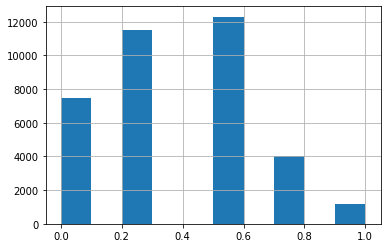

In [14]:
train['score'].hist()

In [15]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [16]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [17]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [18]:
# !pip install --no-cache-dir sentencepiece

In [19]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [20]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [21]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

sys.path.append('../dataset')
from dataset import TrainDataset

torch.__version__: 1.9.0+cu111


In [22]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [23]:
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

In [24]:
class TransformerHead(nn.Module):
    def __init__(self, in_features, max_length, num_layers=1, nhead=8, num_targets=1):
        super().__init__()

        self.transformer = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=in_features,
                                                                                          nhead=nhead),
                                                 num_layers=num_layers)
        self.row_fc = nn.Linear(in_features, 1)
        self.out_features = max_length

    def forward(self, x):
        out = self.transformer(x)
        out = self.row_fc(out).squeeze(-1)
        return out

In [25]:
# class CustomModel(nn.Module):
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
#         self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
#         self._init_weights(self.fc)
#         self.feature_extractor = AutoModelForTokenClassification.from_pretrained("microsoft/deberta-v3-large")
#         self.feature_extractor.save_pretrained(OUTPUT_DIR+'extractor/')
#         # self.feature_extractor = AutoModelForTokenClassification.from_pretrained(OUTPUT_DIR+'extractor/')
#         in_features = self.feature_extractor.classifier.in_features
#         self.attention = TransformerHead(in_features=in_features, max_length=133, num_layers=1, nhead=8, num_targets=1)
                
#         self._init_weights(self.attention)
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         last_hidden_states = outputs[0]
#         # feature = torch.mean(last_hidden_states, 1)
#         weights = self.attention(last_hidden_states)
#         weights = self.attention(weights)
#         feature = torch.sum(weights * last_hidden_states, dim=1)
#         return feature

#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         output = self.fc(self.fc_dropout(feature))
#         return output

In [26]:
import sys
sys.path.append("../../modules/mixout")
from mixout import MixLinear, Mixout

In [27]:
class CustomModelTransformer(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        
        try:
            self.feature_extractor = AutoModelForTokenClassification.from_pretrained(OUTPUT_DIR+'extractor/')
        except:
            self.feature_extractor = AutoModelForTokenClassification.from_pretrained(CFG.model,)
            self.feature_extractor.save_pretrained(OUTPUT_DIR+'extractor/')
        in_features = self.feature_extractor.classifier.in_features
        self.attention = TransformerHead(in_features=in_features, max_length=133, num_layers=1, nhead=8, num_targets=1)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.attention.out_features, self.cfg.target_size)
        self._init_weights(self.fc)
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        feature = self.attention(last_hidden_states)
        
        return feature


    def forward(self, inputs):
        feature = self.feature(inputs)
        #print(feature.shape)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [28]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if "train" in EXP_NAME:
        for sup_module in model.modules():
            for name, module in sup_module.named_children():
                if isinstance(module, nn.Dropout):
                    module.p = 0.0
                if isinstance(module, nn.Linear):
                    target_state_dict = module.state_dict()
                    bias = True if module.bias is not None else False
                    new_module = MixLinear(
                        module.in_features, module.out_features, bias, target_state_dict["weight"], CFG.mixout_prob
                    )
                    new_module.load_state_dict(target_state_dict)
                    setattr(sup_module, name, new_module)

        model.to(device)                
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [29]:
# ====================================================
# train loop
# ====================================================
# def train_loop(folds, fold):
def train_loop(train_loader, valid_loader):

    # ====================================================
    # model & optimizer
    # ====================================================
    if "transformer" in EXP_NAME:
        model = CustomModelTransformer(CFG, config_path=None, pretrained=True)
    else:
        model = CustomModel(CFG, config_path=None, pretrained=True)
    if "all" in EXP_NAME:
        for sup_module in model.modules():
            for name, module in sup_module.named_children():
                if isinstance(module, nn.Dropout):
                    module.p = 0.0
                if isinstance(module, nn.Linear):
                    target_state_dict = module.state_dict()
                    bias = True if module.bias is not None else False
                    new_module = MixLinear(
                        module.in_features, module.out_features, bias, target_state_dict["weight"], CFG.mixout_prob
                    )
                    new_module.load_state_dict(target_state_dict)
                    setattr(sup_module, name, new_module)
        model.to(device)
                
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [30]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            LOGGER.info(f"========== fold: {fold} training ==========")
            print(f"\033[38;5;40m========== fold: {fold} training ==========\033[0m");
            if fold in CFG.trn_fold:
                # ====================================================
                # loader
                # ====================================================
                folds = train
                train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
                valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
                valid_labels = valid_folds['score'].values

                train_dataset = TrainDataset(CFG, train_folds)
                valid_dataset = TrainDataset(CFG, valid_folds)

                train_loader = DataLoader(train_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=False,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#                 _oof_df = train_loop(train, fold)
                _oof_df = train_loop(train_loader, valid_loader)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


========== fold: 0 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3419] Elapsed 0m 0s (remain 42m 59s) Loss: 0.6677(0.6677) Grad: 29417.7559  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 28s (remain 15m 20s) Loss: 0.6603(0.6513) Grad: 15457.6895  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 0m 54s (remain 14m 39s) Loss: 0.6396(0.6562) Grad: 18684.9629  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 1m 21s (remain 14m 7s) Loss: 0.6618(0.6571) Grad: 30090.8242  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 1m 48s (remain 13m 36s) Loss: 0.6437(0.6588) Grad: 1258.5530  LR: 0.00001998  
Epoch: [1][500/3419] Elapsed 2m 15s (remain 13m 8s) Loss: 0.6023(0.6587) Grad: 6956.3706  LR: 0.00001997  
Epoch: [1][600/3419] Elapsed 2m 42s (remain 12m 41s) Loss: 0.6284(0.6560) Grad: 2406.1868  LR: 0.00001996  
Epoch: [1][700/3419] Elapsed 3m 9s (remain 12m 13s) Loss: 0.7132(0.6517) Grad: 6573.3198  LR: 0.00001994  
Epoch: [1][800/3419] Elapsed 3m 36s (remain 11m 46s) Loss: 0.6533(0.6471) Grad: 5571.0601  LR: 0.00001992  
Epoch: [1][900/3419] Elapsed 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 35s) Loss: 0.4583(0.4583) 
EVAL: [100/1140] Elapsed 0m 11s (remain 1m 59s) Loss: 0.5636(0.5587) 
EVAL: [200/1140] Elapsed 0m 22s (remain 1m 47s) Loss: 0.5007(0.5602) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.7449(0.5583) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 23s) Loss: 0.5776(0.5585) 
EVAL: [500/1140] Elapsed 0m 56s (remain 1m 12s) Loss: 0.6091(0.5633) 
EVAL: [600/1140] Elapsed 1m 7s (remain 1m 0s) Loss: 0.5566(0.5607) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.6876(0.5614) 
EVAL: [800/1140] Elapsed 1m 30s (remain 0m 38s) Loss: 0.6703(0.5611) 
EVAL: [900/1140] Elapsed 1m 41s (remain 0m 26s) Loss: 0.4278(0.5605) 
EVAL: [1000/1140] Elapsed 1m 52s (remain 0m 15s) Loss: 0.5126(0.5621) 
EVAL: [1100/1140] Elapsed 2m 4s (remain 0m 4s) Loss: 0.4882(0.5618) 


Epoch 1 - avg_train_loss: 0.6022  avg_val_loss: 0.5614  time: 1048s
Epoch 1 - Score: 0.7904
Epoch 1 - Save Best Score: 0.7904 Model


EVAL: [1139/1140] Elapsed 2m 8s (remain 0m 0s) Loss: 0.6189(0.5614) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 39m 32s) Loss: 0.6342(0.6342) Grad: 29363.4238  LR: 0.00001866  
Epoch: [2][100/3419] Elapsed 0m 29s (remain 16m 19s) Loss: 0.6353(0.5646) Grad: 46517.8633  LR: 0.00001858  
Epoch: [2][200/3419] Elapsed 0m 56s (remain 15m 7s) Loss: 0.5404(0.5616) Grad: 39774.3750  LR: 0.00001850  
Epoch: [2][300/3419] Elapsed 1m 23s (remain 14m 24s) Loss: 0.7155(0.5668) Grad: 70436.3359  LR: 0.00001842  
Epoch: [2][400/3419] Elapsed 1m 50s (remain 13m 49s) Loss: 0.4132(0.5671) Grad: 5675.3853  LR: 0.00001834  
Epoch: [2][500/3419] Elapsed 2m 17s (remain 13m 18s) Loss: 0.6888(0.5674) Grad: 12709.4707  LR: 0.00001825  
Epoch: [2][600/3419] Elapsed 2m 44s (remain 12m 49s) Loss: 0.5025(0.5673) Grad: 7331.6284  LR: 0.00001816  
Epoch: [2][700/3419] Elapsed 3m 10s (remain 12m 20s) Loss: 0.5653(0.5653) Grad: 5855.5386  LR: 0.00001807  
Epoch: [2][800/3419] Elapsed 3m 37s (remain 11m 51s) Loss: 0.5497(0.5649) Grad: 7373.6133  LR: 0.00001798  
Epoch: [2][900/3419] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 29s) Loss: 0.4533(0.4533) 
EVAL: [100/1140] Elapsed 0m 11s (remain 1m 58s) Loss: 0.5400(0.5531) 
EVAL: [200/1140] Elapsed 0m 22s (remain 1m 46s) Loss: 0.4617(0.5535) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 34s) Loss: 0.7661(0.5502) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 23s) Loss: 0.5299(0.5494) 
EVAL: [500/1140] Elapsed 0m 56s (remain 1m 12s) Loss: 0.5851(0.5536) 
EVAL: [600/1140] Elapsed 1m 7s (remain 1m 0s) Loss: 0.5369(0.5505) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.6608(0.5517) 
EVAL: [800/1140] Elapsed 1m 30s (remain 0m 38s) Loss: 0.6895(0.5513) 
EVAL: [900/1140] Elapsed 1m 41s (remain 0m 26s) Loss: 0.4113(0.5506) 
EVAL: [1000/1140] Elapsed 1m 52s (remain 0m 15s) Loss: 0.4911(0.5521) 
EVAL: [1100/1140] Elapsed 2m 4s (remain 0m 4s) Loss: 0.4955(0.5516) 


Epoch 2 - avg_train_loss: 0.5617  avg_val_loss: 0.5514  time: 1050s
Epoch 2 - Score: 0.8162
Epoch 2 - Save Best Score: 0.8162 Model


EVAL: [1139/1140] Elapsed 2m 8s (remain 0m 0s) Loss: 0.6253(0.5514) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 39m 19s) Loss: 0.5735(0.5735) Grad: 35175.2734  LR: 0.00001500  
Epoch: [3][100/3419] Elapsed 0m 27s (remain 15m 4s) Loss: 0.4205(0.5570) Grad: 72526.6250  LR: 0.00001487  
Epoch: [3][200/3419] Elapsed 0m 54s (remain 14m 31s) Loss: 0.5582(0.5445) Grad: 27988.9004  LR: 0.00001473  
Epoch: [3][300/3419] Elapsed 1m 21s (remain 14m 1s) Loss: 0.7952(0.5521) Grad: 45711.4922  LR: 0.00001460  
Epoch: [3][400/3419] Elapsed 1m 48s (remain 13m 33s) Loss: 0.3346(0.5554) Grad: 11149.4746  LR: 0.00001446  
Epoch: [3][500/3419] Elapsed 2m 15s (remain 13m 6s) Loss: 0.4692(0.5522) Grad: 13527.6973  LR: 0.00001432  
Epoch: [3][600/3419] Elapsed 2m 41s (remain 12m 38s) Loss: 0.4977(0.5495) Grad: 9270.6572  LR: 0.00001418  
Epoch: [3][700/3419] Elapsed 3m 8s (remain 12m 11s) Loss: 0.5651(0.5507) Grad: 16094.8662  LR: 0.00001404  
Epoch: [3][800/3419] Elapsed 3m 35s (remain 11m 44s) Loss: 0.5507(0.5511) Grad: 19238.6250  LR: 0.00001390  
Epoch: [3][900/3419] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 38s) Loss: 0.4354(0.4354) 
EVAL: [100/1140] Elapsed 0m 11s (remain 1m 58s) Loss: 0.5312(0.5455) 
EVAL: [200/1140] Elapsed 0m 22s (remain 1m 47s) Loss: 0.4527(0.5489) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.7744(0.5467) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 23s) Loss: 0.5178(0.5462) 
EVAL: [500/1140] Elapsed 0m 56s (remain 1m 12s) Loss: 0.6252(0.5501) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 0s) Loss: 0.5355(0.5474) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.6433(0.5488) 
EVAL: [800/1140] Elapsed 1m 30s (remain 0m 38s) Loss: 0.6866(0.5483) 
EVAL: [900/1140] Elapsed 1m 41s (remain 0m 26s) Loss: 0.4082(0.5475) 
EVAL: [1000/1140] Elapsed 1m 53s (remain 0m 15s) Loss: 0.4841(0.5489) 
EVAL: [1100/1140] Elapsed 2m 4s (remain 0m 4s) Loss: 0.4983(0.5485) 


Epoch 3 - avg_train_loss: 0.5489  avg_val_loss: 0.5484  time: 1048s
Epoch 3 - Score: 0.8239
Epoch 3 - Save Best Score: 0.8239 Model


EVAL: [1139/1140] Elapsed 2m 8s (remain 0m 0s) Loss: 0.6188(0.5484) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 39m 17s) Loss: 0.5543(0.5543) Grad: 90078.2109  LR: 0.00001000  
Epoch: [4][100/3419] Elapsed 0m 27s (remain 15m 2s) Loss: 0.5483(0.5539) Grad: 20704.2324  LR: 0.00000985  
Epoch: [4][200/3419] Elapsed 0m 54s (remain 14m 30s) Loss: 0.5703(0.5517) Grad: 11554.9287  LR: 0.00000969  
Epoch: [4][300/3419] Elapsed 1m 21s (remain 14m 1s) Loss: 0.4745(0.5475) Grad: 13878.5898  LR: 0.00000954  
Epoch: [4][400/3419] Elapsed 1m 48s (remain 13m 33s) Loss: 0.5152(0.5510) Grad: 12385.9932  LR: 0.00000939  
Epoch: [4][500/3419] Elapsed 2m 14s (remain 13m 6s) Loss: 0.4694(0.5510) Grad: 27801.5547  LR: 0.00000923  
Epoch: [4][600/3419] Elapsed 2m 41s (remain 12m 38s) Loss: 0.6560(0.5515) Grad: 26523.6406  LR: 0.00000908  
Epoch: [4][700/3419] Elapsed 3m 8s (remain 12m 11s) Loss: 0.6660(0.5502) Grad: 21704.8184  LR: 0.00000893  
Epoch: [4][800/3419] Elapsed 3m 35s (remain 11m 44s) Loss: 0.7127(0.5496) Grad: 11016.2080  LR: 0.00000878  
Epoch: [4][900/3419] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 43s) Loss: 0.4570(0.4570) 
EVAL: [100/1140] Elapsed 0m 11s (remain 1m 59s) Loss: 0.5322(0.5405) 
EVAL: [200/1140] Elapsed 0m 22s (remain 1m 46s) Loss: 0.4621(0.5430) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.7693(0.5399) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 24s) Loss: 0.5159(0.5402) 
EVAL: [500/1140] Elapsed 0m 56s (remain 1m 12s) Loss: 0.5799(0.5437) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.5377(0.5415) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.6049(0.5427) 
EVAL: [800/1140] Elapsed 1m 30s (remain 0m 38s) Loss: 0.6875(0.5420) 
EVAL: [900/1140] Elapsed 1m 42s (remain 0m 27s) Loss: 0.4079(0.5407) 
EVAL: [1000/1140] Elapsed 1m 53s (remain 0m 15s) Loss: 0.4844(0.5422) 
EVAL: [1100/1140] Elapsed 2m 4s (remain 0m 4s) Loss: 0.4942(0.5418) 


Epoch 4 - avg_train_loss: 0.5453  avg_val_loss: 0.5417  time: 1049s
Epoch 4 - Score: 0.8358
Epoch 4 - Save Best Score: 0.8358 Model


EVAL: [1139/1140] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6152(0.5417) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 41m 42s) Loss: 0.5051(0.5051) Grad: 21255.4395  LR: 0.00000500  
Epoch: [5][100/3419] Elapsed 0m 27s (remain 15m 7s) Loss: 0.5260(0.5350) Grad: 23231.4141  LR: 0.00000487  
Epoch: [5][200/3419] Elapsed 0m 54s (remain 14m 33s) Loss: 0.4718(0.5376) Grad: 25818.4805  LR: 0.00000474  
Epoch: [5][300/3419] Elapsed 1m 21s (remain 14m 3s) Loss: 0.3838(0.5402) Grad: 8824.6396  LR: 0.00000461  
Epoch: [5][400/3419] Elapsed 1m 48s (remain 13m 35s) Loss: 0.5908(0.5390) Grad: 4662.5757  LR: 0.00000448  
Epoch: [5][500/3419] Elapsed 2m 15s (remain 13m 7s) Loss: 0.6167(0.5416) Grad: 7813.0439  LR: 0.00000435  
Epoch: [5][600/3419] Elapsed 2m 42s (remain 12m 40s) Loss: 0.7187(0.5419) Grad: 8897.3965  LR: 0.00000423  
Epoch: [5][700/3419] Elapsed 3m 9s (remain 12m 12s) Loss: 0.5753(0.5401) Grad: 13035.7646  LR: 0.00000410  
Epoch: [5][800/3419] Elapsed 3m 35s (remain 11m 45s) Loss: 0.4923(0.5415) Grad: 3791.7231  LR: 0.00000398  
Epoch: [5][900/3419] Elapsed 4m

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 32s) Loss: 0.4402(0.4402) 
EVAL: [100/1140] Elapsed 0m 11s (remain 1m 58s) Loss: 0.5298(0.5397) 
EVAL: [200/1140] Elapsed 0m 22s (remain 1m 46s) Loss: 0.4551(0.5426) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.7696(0.5401) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 23s) Loss: 0.5164(0.5403) 
EVAL: [500/1140] Elapsed 0m 56s (remain 1m 12s) Loss: 0.5779(0.5442) 
EVAL: [600/1140] Elapsed 1m 7s (remain 1m 0s) Loss: 0.5349(0.5419) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.6144(0.5432) 
EVAL: [800/1140] Elapsed 1m 30s (remain 0m 38s) Loss: 0.6936(0.5425) 
EVAL: [900/1140] Elapsed 1m 41s (remain 0m 27s) Loss: 0.4058(0.5411) 
EVAL: [1000/1140] Elapsed 1m 53s (remain 0m 15s) Loss: 0.4814(0.5425) 
EVAL: [1100/1140] Elapsed 2m 4s (remain 0m 4s) Loss: 0.4965(0.5420) 


Epoch 5 - avg_train_loss: 0.5388  avg_val_loss: 0.5419  time: 1049s
Epoch 5 - Score: 0.8363
Epoch 5 - Save Best Score: 0.8363 Model


EVAL: [1139/1140] Elapsed 2m 8s (remain 0m 0s) Loss: 0.6183(0.5419) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 36m 17s) Loss: 0.4644(0.4644) Grad: 81420.1094  LR: 0.00000134  
Epoch: [6][100/3419] Elapsed 0m 27s (remain 15m 4s) Loss: 0.3621(0.5496) Grad: 31737.0059  LR: 0.00000126  
Epoch: [6][200/3419] Elapsed 0m 54s (remain 14m 30s) Loss: 0.5423(0.5390) Grad: 15747.8457  LR: 0.00000119  
Epoch: [6][300/3419] Elapsed 1m 21s (remain 14m 2s) Loss: 0.4298(0.5392) Grad: 21327.7910  LR: 0.00000112  
Epoch: [6][400/3419] Elapsed 1m 48s (remain 13m 34s) Loss: 0.3304(0.5411) Grad: 11242.0918  LR: 0.00000105  
Epoch: [6][500/3419] Elapsed 2m 15s (remain 13m 6s) Loss: 0.5248(0.5414) Grad: 71192.4453  LR: 0.00000098  
Epoch: [6][600/3419] Elapsed 2m 41s (remain 12m 39s) Loss: 0.5257(0.5404) Grad: 27442.3535  LR: 0.00000092  
Epoch: [6][700/3419] Elapsed 3m 8s (remain 12m 12s) Loss: 0.5097(0.5394) Grad: 32399.7324  LR: 0.00000085  
Epoch: [6][800/3419] Elapsed 3m 35s (remain 11m 45s) Loss: 0.4852(0.5396) Grad: 29364.5352  LR: 0.00000079  
Epoch: [6][900/3419] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][3418/3419] Elapsed 15m 19s (remain 0m 0s) Loss: 0.6269(0.5372) Grad: 11397.1016  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 44s) Loss: 0.4371(0.4371) 
EVAL: [100/1140] Elapsed 0m 11s (remain 2m 0s) Loss: 0.5286(0.5402) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 47s) Loss: 0.4562(0.5430) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.7728(0.5408) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 24s) Loss: 0.5164(0.5411) 
EVAL: [500/1140] Elapsed 0m 57s (remain 1m 12s) Loss: 0.5780(0.5450) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.5327(0.5425) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.6138(0.5439) 
EVAL: [800/1140] Elapsed 1m 31s (remain 0m 38s) Loss: 0.6949(0.5434) 
EVAL: [900/1140] Elapsed 1m 42s (remain 0m 27s) Loss: 0.4059(0.5418) 
EVAL: [1000/1140] Elapsed 1m 53s (remain 0m 15s) Loss: 0.4812(0.5433) 
EVAL: [1100/1140] Elapsed 2m 5s (remain 0m 4s) Loss: 0.4959(0.5427) 


Epoch 6 - avg_train_loss: 0.5372  avg_val_loss: 0.5427  time: 1049s
Epoch 6 - Score: 0.8362


EVAL: [1139/1140] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6201(0.5427) 


========== fold: 0 result ==========
Score: 0.8363
========== fold: 1 training ==========


========== fold: 1 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.cc

Epoch: [1][0/3419] Elapsed 0m 0s (remain 32m 10s) Loss: 0.6995(0.6995) Grad: 17160.1543  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 27s (remain 15m 8s) Loss: 0.6783(0.6593) Grad: 11902.8555  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 0m 54s (remain 14m 33s) Loss: 0.5731(0.6595) Grad: 79617.2578  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 1m 21s (remain 14m 4s) Loss: 0.6804(0.6583) Grad: 20991.1289  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 1m 48s (remain 13m 36s) Loss: 0.6930(0.6550) Grad: 57518.8867  LR: 0.00001998  
Epoch: [1][500/3419] Elapsed 2m 15s (remain 13m 9s) Loss: 0.6261(0.6540) Grad: 38320.8281  LR: 0.00001997  
Epoch: [1][600/3419] Elapsed 2m 42s (remain 12m 41s) Loss: 0.5782(0.6524) Grad: 50294.5859  LR: 0.00001996  
Epoch: [1][700/3419] Elapsed 3m 9s (remain 12m 14s) Loss: 0.7221(0.6499) Grad: 79382.5391  LR: 0.00001994  
Epoch: [1][800/3419] Elapsed 3m 36s (remain 11m 46s) Loss: 0.5353(0.6467) Grad: 99647.9141  LR: 0.00001992  
Epoch: [1][900/3419] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 18s) Loss: 0.4978(0.4978) 
EVAL: [100/1140] Elapsed 0m 11s (remain 2m 0s) Loss: 0.5684(0.5407) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 47s) Loss: 0.5068(0.5480) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.6087(0.5519) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 24s) Loss: 0.3841(0.5542) 
EVAL: [500/1140] Elapsed 0m 57s (remain 1m 12s) Loss: 0.6094(0.5574) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.6036(0.5576) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.6948(0.5563) 
EVAL: [800/1140] Elapsed 1m 31s (remain 0m 38s) Loss: 0.5409(0.5574) 
EVAL: [900/1140] Elapsed 1m 42s (remain 0m 27s) Loss: 0.4969(0.5565) 
EVAL: [1000/1140] Elapsed 1m 53s (remain 0m 15s) Loss: 0.5441(0.5553) 
EVAL: [1100/1140] Elapsed 2m 5s (remain 0m 4s) Loss: 0.4019(0.5540) 


Epoch 1 - avg_train_loss: 0.6049  avg_val_loss: 0.5546  time: 1051s
Epoch 1 - Score: 0.7941
Epoch 1 - Save Best Score: 0.7941 Model


EVAL: [1139/1140] Elapsed 2m 9s (remain 0m 0s) Loss: 0.7478(0.5546) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 44m 1s) Loss: 0.6328(0.6328) Grad: 64614.3867  LR: 0.00001866  
Epoch: [2][100/3419] Elapsed 0m 27s (remain 15m 8s) Loss: 0.4134(0.5674) Grad: 40903.8672  LR: 0.00001858  
Epoch: [2][200/3419] Elapsed 0m 54s (remain 14m 33s) Loss: 0.5239(0.5651) Grad: 83909.0703  LR: 0.00001850  
Epoch: [2][300/3419] Elapsed 1m 21s (remain 14m 4s) Loss: 0.5771(0.5637) Grad: 38264.6719  LR: 0.00001842  
Epoch: [2][400/3419] Elapsed 1m 48s (remain 13m 35s) Loss: 0.6093(0.5629) Grad: 36589.2656  LR: 0.00001834  
Epoch: [2][500/3419] Elapsed 2m 15s (remain 13m 8s) Loss: 0.7024(0.5628) Grad: 97821.6797  LR: 0.00001825  
Epoch: [2][600/3419] Elapsed 2m 42s (remain 12m 40s) Loss: 0.6106(0.5624) Grad: 47330.7812  LR: 0.00001816  
Epoch: [2][700/3419] Elapsed 3m 9s (remain 12m 13s) Loss: 0.4016(0.5625) Grad: 33494.0625  LR: 0.00001808  
Epoch: [2][800/3419] Elapsed 3m 36s (remain 11m 46s) Loss: 0.4862(0.5631) Grad: 22142.8047  LR: 0.00001798  
Epoch: [2][900/3419] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 19s) Loss: 0.4512(0.4512) 
EVAL: [100/1140] Elapsed 0m 11s (remain 1m 59s) Loss: 0.5533(0.5305) 
EVAL: [200/1140] Elapsed 0m 22s (remain 1m 47s) Loss: 0.4864(0.5423) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.6035(0.5433) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 23s) Loss: 0.3600(0.5454) 
EVAL: [500/1140] Elapsed 0m 56s (remain 1m 12s) Loss: 0.6777(0.5494) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.5960(0.5501) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.6919(0.5483) 
EVAL: [800/1140] Elapsed 1m 30s (remain 0m 38s) Loss: 0.5456(0.5497) 
EVAL: [900/1140] Elapsed 1m 42s (remain 0m 27s) Loss: 0.4917(0.5487) 
EVAL: [1000/1140] Elapsed 1m 53s (remain 0m 15s) Loss: 0.5398(0.5477) 
EVAL: [1100/1140] Elapsed 2m 4s (remain 0m 4s) Loss: 0.3801(0.5466) 


Epoch 2 - avg_train_loss: 0.5599  avg_val_loss: 0.5474  time: 1051s
Epoch 2 - Score: 0.8192
Epoch 2 - Save Best Score: 0.8192 Model


EVAL: [1139/1140] Elapsed 2m 9s (remain 0m 0s) Loss: 0.7757(0.5474) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 44m 3s) Loss: 0.5991(0.5991) Grad: 138315.7344  LR: 0.00001500  
Epoch: [3][100/3419] Elapsed 0m 27s (remain 15m 8s) Loss: 0.4213(0.5388) Grad: 41678.8359  LR: 0.00001487  
Epoch: [3][200/3419] Elapsed 0m 54s (remain 14m 33s) Loss: 0.5235(0.5397) Grad: 64608.9492  LR: 0.00001473  
Epoch: [3][300/3419] Elapsed 1m 21s (remain 14m 4s) Loss: 0.4642(0.5399) Grad: 60121.5781  LR: 0.00001460  
Epoch: [3][400/3419] Elapsed 1m 48s (remain 13m 36s) Loss: 0.6126(0.5428) Grad: 137958.9219  LR: 0.00001446  
Epoch: [3][500/3419] Elapsed 2m 15s (remain 13m 8s) Loss: 0.5065(0.5421) Grad: 23203.2793  LR: 0.00001432  
Epoch: [3][600/3419] Elapsed 2m 42s (remain 12m 41s) Loss: 0.6157(0.5443) Grad: 36822.4102  LR: 0.00001418  
Epoch: [3][700/3419] Elapsed 3m 9s (remain 12m 13s) Loss: 0.6428(0.5454) Grad: 24159.0723  LR: 0.00001404  
Epoch: [3][800/3419] Elapsed 3m 36s (remain 11m 46s) Loss: 0.6777(0.5475) Grad: 14455.8008  LR: 0.00001390  
Epoch: [3][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 17s) Loss: 0.4484(0.4484) 
EVAL: [100/1140] Elapsed 0m 11s (remain 1m 59s) Loss: 0.5385(0.5307) 
EVAL: [200/1140] Elapsed 0m 22s (remain 1m 47s) Loss: 0.4869(0.5381) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.6000(0.5414) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 24s) Loss: 0.3989(0.5435) 
EVAL: [500/1140] Elapsed 0m 56s (remain 1m 12s) Loss: 0.6978(0.5467) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.6013(0.5473) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.6921(0.5457) 
EVAL: [800/1140] Elapsed 1m 31s (remain 0m 38s) Loss: 0.5486(0.5462) 
EVAL: [900/1140] Elapsed 1m 42s (remain 0m 27s) Loss: 0.4907(0.5449) 
EVAL: [1000/1140] Elapsed 1m 53s (remain 0m 15s) Loss: 0.5448(0.5443) 
EVAL: [1100/1140] Elapsed 2m 5s (remain 0m 4s) Loss: 0.4056(0.5428) 


Epoch 3 - avg_train_loss: 0.5489  avg_val_loss: 0.5433  time: 1051s
Epoch 3 - Score: 0.8296
Epoch 3 - Save Best Score: 0.8296 Model


EVAL: [1139/1140] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6338(0.5433) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 41m 42s) Loss: 0.4993(0.4993) Grad: 44339.4844  LR: 0.00001000  
Epoch: [4][100/3419] Elapsed 0m 27s (remain 15m 6s) Loss: 0.6782(0.5354) Grad: 2161.4829  LR: 0.00000985  
Epoch: [4][200/3419] Elapsed 0m 54s (remain 14m 33s) Loss: 0.3071(0.5333) Grad: 6673.5254  LR: 0.00000969  
Epoch: [4][300/3419] Elapsed 1m 21s (remain 14m 3s) Loss: 0.4487(0.5367) Grad: 13326.9004  LR: 0.00000954  
Epoch: [4][400/3419] Elapsed 1m 48s (remain 13m 35s) Loss: 0.4534(0.5418) Grad: 13178.9209  LR: 0.00000939  
Epoch: [4][500/3419] Elapsed 2m 15s (remain 13m 7s) Loss: 0.5022(0.5420) Grad: 10990.3975  LR: 0.00000924  
Epoch: [4][600/3419] Elapsed 2m 42s (remain 12m 40s) Loss: 0.7127(0.5416) Grad: 18069.5859  LR: 0.00000908  
Epoch: [4][700/3419] Elapsed 3m 9s (remain 12m 13s) Loss: 0.7192(0.5426) Grad: 28361.8945  LR: 0.00000893  
Epoch: [4][800/3419] Elapsed 3m 36s (remain 11m 45s) Loss: 0.2794(0.5424) Grad: 20867.5488  LR: 0.00000878  
Epoch: [4][900/3419] Elapsed

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 17s) Loss: 0.4600(0.4600) 
EVAL: [100/1140] Elapsed 0m 11s (remain 1m 59s) Loss: 0.5434(0.5272) 
EVAL: [200/1140] Elapsed 0m 22s (remain 1m 46s) Loss: 0.4809(0.5396) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.6062(0.5414) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 23s) Loss: 0.3629(0.5434) 
EVAL: [500/1140] Elapsed 0m 56s (remain 1m 12s) Loss: 0.7226(0.5463) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.5935(0.5468) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.7026(0.5456) 
EVAL: [800/1140] Elapsed 1m 30s (remain 0m 38s) Loss: 0.5541(0.5465) 
EVAL: [900/1140] Elapsed 1m 41s (remain 0m 27s) Loss: 0.4903(0.5453) 
EVAL: [1000/1140] Elapsed 1m 53s (remain 0m 15s) Loss: 0.5384(0.5446) 
EVAL: [1100/1140] Elapsed 2m 4s (remain 0m 4s) Loss: 0.3956(0.5436) 


Epoch 4 - avg_train_loss: 0.5424  avg_val_loss: 0.5442  time: 1050s
Epoch 4 - Score: 0.8327
Epoch 4 - Save Best Score: 0.8327 Model


EVAL: [1139/1140] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6901(0.5442) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 39m 35s) Loss: 0.5006(0.5006) Grad: 60321.4219  LR: 0.00000500  
Epoch: [5][100/3419] Elapsed 0m 27s (remain 15m 7s) Loss: 0.5077(0.5355) Grad: 66192.0625  LR: 0.00000487  
Epoch: [5][200/3419] Elapsed 0m 54s (remain 14m 32s) Loss: 0.5767(0.5371) Grad: 17182.2012  LR: 0.00000474  
Epoch: [5][300/3419] Elapsed 1m 21s (remain 14m 3s) Loss: 0.4182(0.5325) Grad: 8220.5605  LR: 0.00000461  
Epoch: [5][400/3419] Elapsed 1m 48s (remain 13m 35s) Loss: 0.2576(0.5355) Grad: 11367.5010  LR: 0.00000448  
Epoch: [5][500/3419] Elapsed 2m 15s (remain 13m 8s) Loss: 0.5818(0.5357) Grad: 115981.9844  LR: 0.00000435  
Epoch: [5][600/3419] Elapsed 2m 42s (remain 12m 40s) Loss: 0.6125(0.5344) Grad: 26427.3184  LR: 0.00000423  
Epoch: [5][700/3419] Elapsed 3m 9s (remain 12m 13s) Loss: 0.4936(0.5335) Grad: 14701.1904  LR: 0.00000410  
Epoch: [5][800/3419] Elapsed 3m 36s (remain 11m 46s) Loss: 0.5377(0.5325) Grad: 27653.1758  LR: 0.00000398  
Epoch: [5][900/3419] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][3418/3419] Elapsed 15m 21s (remain 0m 0s) Loss: 0.5377(0.5375) Grad: 5047.9116  LR: 0.00000134  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 13s) Loss: 0.4654(0.4654) 
EVAL: [100/1140] Elapsed 0m 11s (remain 1m 59s) Loss: 0.5407(0.5270) 
EVAL: [200/1140] Elapsed 0m 22s (remain 1m 47s) Loss: 0.4800(0.5407) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.6043(0.5426) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 24s) Loss: 0.3641(0.5446) 
EVAL: [500/1140] Elapsed 0m 56s (remain 1m 12s) Loss: 0.7348(0.5475) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.5892(0.5483) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.7133(0.5473) 
EVAL: [800/1140] Elapsed 1m 31s (remain 0m 38s) Loss: 0.5554(0.5480) 
EVAL: [900/1140] Elapsed 1m 42s (remain 0m 27s) Loss: 0.4887(0.5467) 
EVAL: [1000/1140] Elapsed 1m 53s (remain 0m 15s) Loss: 0.5361(0.5460) 
EVAL: [1100/1140] Elapsed 2m 5s (remain 0m 4s) Loss: 0.3994(0.5450) 


Epoch 5 - avg_train_loss: 0.5375  avg_val_loss: 0.5457  time: 1051s
Epoch 5 - Score: 0.8337
Epoch 5 - Save Best Score: 0.8337 Model


EVAL: [1139/1140] Elapsed 2m 9s (remain 0m 0s) Loss: 0.7575(0.5457) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 43m 23s) Loss: 0.5731(0.5731) Grad: 38952.0508  LR: 0.00000134  
Epoch: [6][100/3419] Elapsed 0m 27s (remain 15m 9s) Loss: 0.5867(0.5397) Grad: 19431.7148  LR: 0.00000126  
Epoch: [6][200/3419] Elapsed 0m 54s (remain 14m 33s) Loss: 0.4116(0.5471) Grad: 6994.2593  LR: 0.00000119  
Epoch: [6][300/3419] Elapsed 1m 21s (remain 14m 3s) Loss: 0.5538(0.5441) Grad: 9746.3721  LR: 0.00000112  
Epoch: [6][400/3419] Elapsed 1m 48s (remain 13m 35s) Loss: 0.6677(0.5414) Grad: 3034.6318  LR: 0.00000105  
Epoch: [6][500/3419] Elapsed 2m 15s (remain 13m 8s) Loss: 0.5806(0.5416) Grad: 9118.4775  LR: 0.00000098  
Epoch: [6][600/3419] Elapsed 2m 42s (remain 12m 40s) Loss: 0.3827(0.5431) Grad: 14138.2773  LR: 0.00000092  
Epoch: [6][700/3419] Elapsed 3m 9s (remain 12m 13s) Loss: 0.5559(0.5400) Grad: 35030.1211  LR: 0.00000085  
Epoch: [6][800/3419] Elapsed 3m 36s (remain 11m 46s) Loss: 0.6084(0.5414) Grad: 20971.5801  LR: 0.00000079  
Epoch: [6][900/3419] Elapsed 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 17s) Loss: 0.4638(0.4638) 
EVAL: [100/1140] Elapsed 0m 11s (remain 2m 0s) Loss: 0.5280(0.5258) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 47s) Loss: 0.4807(0.5388) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.6043(0.5411) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 24s) Loss: 0.3673(0.5432) 
EVAL: [500/1140] Elapsed 0m 56s (remain 1m 12s) Loss: 0.7204(0.5462) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.5901(0.5469) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.7115(0.5459) 
EVAL: [800/1140] Elapsed 1m 30s (remain 0m 38s) Loss: 0.5494(0.5466) 
EVAL: [900/1140] Elapsed 1m 42s (remain 0m 27s) Loss: 0.4889(0.5453) 
EVAL: [1000/1140] Elapsed 1m 53s (remain 0m 15s) Loss: 0.5345(0.5446) 
EVAL: [1100/1140] Elapsed 2m 4s (remain 0m 4s) Loss: 0.3983(0.5436) 


Epoch 6 - avg_train_loss: 0.5362  avg_val_loss: 0.5442  time: 1051s
Epoch 6 - Score: 0.8344
Epoch 6 - Save Best Score: 0.8344 Model


EVAL: [1139/1140] Elapsed 2m 9s (remain 0m 0s) Loss: 0.7082(0.5442) 


========== fold: 1 result ==========
Score: 0.8344
========== fold: 2 training ==========


========== fold: 2 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.cc

Epoch: [1][0/3419] Elapsed 0m 0s (remain 26m 48s) Loss: 0.6718(0.6718) Grad: 34899.4609  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 27s (remain 15m 0s) Loss: 0.6937(0.6631) Grad: 14519.3594  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 0m 54s (remain 14m 29s) Loss: 0.6653(0.6628) Grad: 4090.6895  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 1m 21s (remain 14m 1s) Loss: 0.6027(0.6579) Grad: 5525.7842  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 1m 48s (remain 13m 33s) Loss: 0.6764(0.6580) Grad: 7825.4199  LR: 0.00001998  
Epoch: [1][500/3419] Elapsed 2m 15s (remain 13m 6s) Loss: 0.6551(0.6548) Grad: 4780.7944  LR: 0.00001997  
Epoch: [1][600/3419] Elapsed 2m 41s (remain 12m 39s) Loss: 0.7415(0.6518) Grad: 42972.1680  LR: 0.00001996  
Epoch: [1][700/3419] Elapsed 3m 8s (remain 12m 12s) Loss: 0.6542(0.6503) Grad: 17843.2012  LR: 0.00001994  
Epoch: [1][800/3419] Elapsed 3m 35s (remain 11m 45s) Loss: 0.5971(0.6470) Grad: 18953.6055  LR: 0.00001992  
Epoch: [1][900/3419] Elapsed 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 22s) Loss: 0.5336(0.5336) 
EVAL: [100/1140] Elapsed 0m 11s (remain 2m 0s) Loss: 0.7144(0.5641) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 47s) Loss: 0.6645(0.5632) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.5552(0.5688) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 24s) Loss: 0.5375(0.5724) 
EVAL: [500/1140] Elapsed 0m 57s (remain 1m 12s) Loss: 0.5116(0.5692) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.3632(0.5705) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.5947(0.5710) 
EVAL: [800/1140] Elapsed 1m 31s (remain 0m 38s) Loss: 0.2533(0.5718) 
EVAL: [900/1140] Elapsed 1m 42s (remain 0m 27s) Loss: 0.6163(0.5708) 
EVAL: [1000/1140] Elapsed 1m 53s (remain 0m 15s) Loss: 0.5158(0.5703) 
EVAL: [1100/1140] Elapsed 2m 5s (remain 0m 4s) Loss: 0.6589(0.5692) 


Epoch 1 - avg_train_loss: 0.6009  avg_val_loss: 0.5694  time: 1051s
Epoch 1 - Score: 0.7539
Epoch 1 - Save Best Score: 0.7539 Model


EVAL: [1139/1140] Elapsed 2m 9s (remain 0m 0s) Loss: 0.4669(0.5694) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 38m 49s) Loss: 0.5462(0.5462) Grad: 85764.5938  LR: 0.00001866  
Epoch: [2][100/3419] Elapsed 0m 27s (remain 15m 5s) Loss: 0.7907(0.5544) Grad: 114699.5000  LR: 0.00001858  
Epoch: [2][200/3419] Elapsed 0m 54s (remain 14m 32s) Loss: 0.5864(0.5588) Grad: 12147.0674  LR: 0.00001850  
Epoch: [2][300/3419] Elapsed 1m 21s (remain 14m 3s) Loss: 0.5958(0.5616) Grad: 28758.7441  LR: 0.00001842  
Epoch: [2][400/3419] Elapsed 1m 48s (remain 13m 35s) Loss: 0.5283(0.5636) Grad: 14323.6377  LR: 0.00001834  
Epoch: [2][500/3419] Elapsed 2m 15s (remain 13m 7s) Loss: 0.5155(0.5652) Grad: 22574.0391  LR: 0.00001825  
Epoch: [2][600/3419] Elapsed 2m 42s (remain 12m 40s) Loss: 0.5311(0.5635) Grad: 36311.5977  LR: 0.00001816  
Epoch: [2][700/3419] Elapsed 3m 9s (remain 12m 13s) Loss: 0.6533(0.5642) Grad: 31108.1035  LR: 0.00001808  
Epoch: [2][800/3419] Elapsed 3m 36s (remain 11m 46s) Loss: 0.5640(0.5637) Grad: 38373.6445  LR: 0.00001798  
Epoch: [2][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 23s) Loss: 0.4817(0.4817) 
EVAL: [100/1140] Elapsed 0m 11s (remain 2m 0s) Loss: 0.6991(0.5469) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 47s) Loss: 0.6515(0.5464) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.5683(0.5557) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 24s) Loss: 0.5001(0.5602) 
EVAL: [500/1140] Elapsed 0m 57s (remain 1m 12s) Loss: 0.4732(0.5563) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.2998(0.5576) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.5428(0.5577) 
EVAL: [800/1140] Elapsed 1m 31s (remain 0m 38s) Loss: 0.2492(0.5581) 
EVAL: [900/1140] Elapsed 1m 42s (remain 0m 27s) Loss: 0.6139(0.5576) 
EVAL: [1000/1140] Elapsed 1m 53s (remain 0m 15s) Loss: 0.4852(0.5569) 
EVAL: [1100/1140] Elapsed 2m 5s (remain 0m 4s) Loss: 0.6424(0.5555) 


Epoch 2 - avg_train_loss: 0.5603  avg_val_loss: 0.5561  time: 1051s
Epoch 2 - Score: 0.8015
Epoch 2 - Save Best Score: 0.8015 Model


EVAL: [1139/1140] Elapsed 2m 9s (remain 0m 0s) Loss: 0.4571(0.5561) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 44m 28s) Loss: 0.5106(0.5106) Grad: 45547.5664  LR: 0.00001500  
Epoch: [3][100/3419] Elapsed 0m 27s (remain 15m 6s) Loss: 0.4820(0.5390) Grad: 13710.6943  LR: 0.00001487  
Epoch: [3][200/3419] Elapsed 0m 54s (remain 14m 32s) Loss: 0.6273(0.5429) Grad: 22844.9395  LR: 0.00001473  
Epoch: [3][300/3419] Elapsed 1m 21s (remain 14m 3s) Loss: 0.5101(0.5422) Grad: 9842.7188  LR: 0.00001460  
Epoch: [3][400/3419] Elapsed 1m 48s (remain 13m 35s) Loss: 0.3602(0.5433) Grad: 12429.0410  LR: 0.00001446  
Epoch: [3][500/3419] Elapsed 2m 15s (remain 13m 8s) Loss: 0.5857(0.5445) Grad: 9073.8359  LR: 0.00001432  
Epoch: [3][600/3419] Elapsed 2m 42s (remain 12m 40s) Loss: 0.6325(0.5451) Grad: 10295.0488  LR: 0.00001418  
Epoch: [3][700/3419] Elapsed 3m 9s (remain 12m 13s) Loss: 0.5700(0.5451) Grad: 8807.3604  LR: 0.00001404  
Epoch: [3][800/3419] Elapsed 3m 36s (remain 11m 46s) Loss: 0.3962(0.5451) Grad: 18553.8223  LR: 0.00001390  
Epoch: [3][900/3419] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][3418/3419] Elapsed 15m 21s (remain 0m 0s) Loss: 0.4596(0.5472) Grad: 16408.1738  LR: 0.00001000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 25s) Loss: 0.4820(0.4820) 
EVAL: [100/1140] Elapsed 0m 11s (remain 2m 1s) Loss: 0.6923(0.5461) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 48s) Loss: 0.6489(0.5437) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 36s) Loss: 0.5851(0.5510) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 24s) Loss: 0.4865(0.5554) 
EVAL: [500/1140] Elapsed 0m 57s (remain 1m 13s) Loss: 0.4739(0.5521) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.2718(0.5540) 
EVAL: [700/1140] Elapsed 1m 20s (remain 0m 50s) Loss: 0.5925(0.5541) 
EVAL: [800/1140] Elapsed 1m 31s (remain 0m 38s) Loss: 0.2419(0.5544) 
EVAL: [900/1140] Elapsed 1m 42s (remain 0m 27s) Loss: 0.6155(0.5541) 
EVAL: [1000/1140] Elapsed 1m 54s (remain 0m 15s) Loss: 0.4681(0.5534) 
EVAL: [1100/1140] Elapsed 2m 5s (remain 0m 4s) Loss: 0.6484(0.5518) 


Epoch 3 - avg_train_loss: 0.5472  avg_val_loss: 0.5523  time: 1052s
Epoch 3 - Score: 0.8104
Epoch 3 - Save Best Score: 0.8104 Model


EVAL: [1139/1140] Elapsed 2m 10s (remain 0m 0s) Loss: 0.4519(0.5523) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 45m 57s) Loss: 0.4920(0.4920) Grad: 21605.1191  LR: 0.00001000  
Epoch: [4][100/3419] Elapsed 0m 27s (remain 15m 8s) Loss: 0.5176(0.5270) Grad: 9496.6045  LR: 0.00000985  
Epoch: [4][200/3419] Elapsed 0m 54s (remain 14m 34s) Loss: 0.5689(0.5333) Grad: 7333.4883  LR: 0.00000969  
Epoch: [4][300/3419] Elapsed 1m 21s (remain 14m 5s) Loss: 0.3659(0.5394) Grad: 17144.2930  LR: 0.00000954  
Epoch: [4][400/3419] Elapsed 1m 48s (remain 13m 36s) Loss: 0.5970(0.5416) Grad: 17760.5938  LR: 0.00000939  
Epoch: [4][500/3419] Elapsed 2m 15s (remain 13m 9s) Loss: 0.4886(0.5411) Grad: 10140.3789  LR: 0.00000924  
Epoch: [4][600/3419] Elapsed 2m 42s (remain 12m 41s) Loss: 0.4196(0.5423) Grad: 8681.3350  LR: 0.00000908  
Epoch: [4][700/3419] Elapsed 3m 9s (remain 12m 14s) Loss: 0.5718(0.5422) Grad: 12804.9062  LR: 0.00000893  
Epoch: [4][800/3419] Elapsed 3m 36s (remain 11m 47s) Loss: 0.3527(0.5438) Grad: 11840.5146  LR: 0.00000878  
Epoch: [4][900/3419] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][3418/3419] Elapsed 15m 22s (remain 0m 0s) Loss: 0.6295(0.5405) Grad: 14365.5869  LR: 0.00000500  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 26s) Loss: 0.4816(0.4816) 
EVAL: [100/1140] Elapsed 0m 11s (remain 2m 1s) Loss: 0.6983(0.5414) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 49s) Loss: 0.6481(0.5417) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 37s) Loss: 0.5868(0.5498) 
EVAL: [400/1140] Elapsed 0m 46s (remain 1m 25s) Loss: 0.4846(0.5538) 
EVAL: [500/1140] Elapsed 0m 57s (remain 1m 13s) Loss: 0.4683(0.5508) 
EVAL: [600/1140] Elapsed 1m 9s (remain 1m 1s) Loss: 0.2677(0.5524) 
EVAL: [700/1140] Elapsed 1m 20s (remain 0m 50s) Loss: 0.5801(0.5526) 
EVAL: [800/1140] Elapsed 1m 31s (remain 0m 38s) Loss: 0.2389(0.5531) 
EVAL: [900/1140] Elapsed 1m 43s (remain 0m 27s) Loss: 0.5856(0.5527) 
EVAL: [1000/1140] Elapsed 1m 54s (remain 0m 15s) Loss: 0.4687(0.5521) 
EVAL: [1100/1140] Elapsed 2m 6s (remain 0m 4s) Loss: 0.6432(0.5503) 


Epoch 4 - avg_train_loss: 0.5405  avg_val_loss: 0.5508  time: 1053s
Epoch 4 - Score: 0.8177
Epoch 4 - Save Best Score: 0.8177 Model


EVAL: [1139/1140] Elapsed 2m 10s (remain 0m 0s) Loss: 0.4590(0.5508) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 38m 45s) Loss: 0.4942(0.4942) Grad: 17392.0449  LR: 0.00000500  
Epoch: [5][100/3419] Elapsed 0m 27s (remain 15m 6s) Loss: 0.3881(0.5293) Grad: 32989.4375  LR: 0.00000487  
Epoch: [5][200/3419] Elapsed 0m 54s (remain 14m 31s) Loss: 0.5046(0.5376) Grad: 10757.8174  LR: 0.00000474  
Epoch: [5][300/3419] Elapsed 1m 21s (remain 14m 2s) Loss: 0.4624(0.5399) Grad: 11225.3730  LR: 0.00000461  
Epoch: [5][400/3419] Elapsed 1m 48s (remain 13m 35s) Loss: 0.4872(0.5387) Grad: 11731.8545  LR: 0.00000448  
Epoch: [5][500/3419] Elapsed 2m 15s (remain 13m 7s) Loss: 0.5023(0.5350) Grad: 12064.0938  LR: 0.00000435  
Epoch: [5][600/3419] Elapsed 2m 42s (remain 12m 40s) Loss: 0.5699(0.5355) Grad: 14532.3125  LR: 0.00000423  
Epoch: [5][700/3419] Elapsed 3m 9s (remain 12m 13s) Loss: 0.4537(0.5340) Grad: 9658.0107  LR: 0.00000410  
Epoch: [5][800/3419] Elapsed 3m 36s (remain 11m 46s) Loss: 0.5744(0.5361) Grad: 17460.2480  LR: 0.00000398  
Epoch: [5][900/3419] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 23s) Loss: 0.4922(0.4922) 
EVAL: [100/1140] Elapsed 0m 11s (remain 2m 0s) Loss: 0.7097(0.5443) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 47s) Loss: 0.6470(0.5436) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.5824(0.5515) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 24s) Loss: 0.4835(0.5570) 
EVAL: [500/1140] Elapsed 0m 57s (remain 1m 12s) Loss: 0.4704(0.5537) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.2659(0.5551) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 50s) Loss: 0.5947(0.5549) 
EVAL: [800/1140] Elapsed 1m 31s (remain 0m 38s) Loss: 0.2373(0.5547) 
EVAL: [900/1140] Elapsed 1m 42s (remain 0m 27s) Loss: 0.5788(0.5543) 
EVAL: [1000/1140] Elapsed 1m 54s (remain 0m 15s) Loss: 0.4663(0.5536) 
EVAL: [1100/1140] Elapsed 2m 5s (remain 0m 4s) Loss: 0.6448(0.5519) 


Epoch 5 - avg_train_loss: 0.5352  avg_val_loss: 0.5524  time: 1052s
Epoch 5 - Score: 0.8173


EVAL: [1139/1140] Elapsed 2m 9s (remain 0m 0s) Loss: 0.4610(0.5524) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 25m 26s) Loss: 0.4835(0.4835) Grad: 64518.7656  LR: 0.00000134  
Epoch: [6][100/3419] Elapsed 0m 27s (remain 14m 58s) Loss: 0.6664(0.5361) Grad: 12896.2744  LR: 0.00000126  
Epoch: [6][200/3419] Elapsed 0m 54s (remain 14m 28s) Loss: 0.5654(0.5334) Grad: 29444.1777  LR: 0.00000119  
Epoch: [6][300/3419] Elapsed 1m 21s (remain 14m 0s) Loss: 0.5144(0.5427) Grad: 15293.3428  LR: 0.00000112  
Epoch: [6][400/3419] Elapsed 1m 48s (remain 13m 33s) Loss: 0.6282(0.5402) Grad: 19413.6094  LR: 0.00000105  
Epoch: [6][500/3419] Elapsed 2m 15s (remain 13m 6s) Loss: 0.4848(0.5386) Grad: 5718.6611  LR: 0.00000098  
Epoch: [6][600/3419] Elapsed 2m 42s (remain 12m 39s) Loss: 0.4649(0.5342) Grad: 9295.3193  LR: 0.00000092  
Epoch: [6][700/3419] Elapsed 3m 8s (remain 12m 12s) Loss: 0.5534(0.5320) Grad: 10854.5654  LR: 0.00000085  
Epoch: [6][800/3419] Elapsed 3m 35s (remain 11m 45s) Loss: 0.4010(0.5331) Grad: 19282.4473  LR: 0.00000079  
Epoch: [6][900/3419] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 29s) Loss: 0.4888(0.4888) 
EVAL: [100/1140] Elapsed 0m 11s (remain 2m 0s) Loss: 0.7147(0.5459) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 47s) Loss: 0.6474(0.5451) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 36s) Loss: 0.5860(0.5529) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 24s) Loss: 0.4843(0.5583) 
EVAL: [500/1140] Elapsed 0m 57s (remain 1m 12s) Loss: 0.4725(0.5551) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.2664(0.5565) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 50s) Loss: 0.5889(0.5562) 
EVAL: [800/1140] Elapsed 1m 31s (remain 0m 38s) Loss: 0.2380(0.5560) 
EVAL: [900/1140] Elapsed 1m 42s (remain 0m 27s) Loss: 0.5795(0.5556) 
EVAL: [1000/1140] Elapsed 1m 54s (remain 0m 15s) Loss: 0.4661(0.5547) 
EVAL: [1100/1140] Elapsed 2m 5s (remain 0m 4s) Loss: 0.6446(0.5530) 


Epoch 6 - avg_train_loss: 0.5332  avg_val_loss: 0.5535  time: 1051s
Epoch 6 - Score: 0.8181
Epoch 6 - Save Best Score: 0.8181 Model


EVAL: [1139/1140] Elapsed 2m 9s (remain 0m 0s) Loss: 0.4611(0.5535) 


========== fold: 2 result ==========
Score: 0.8181
========== fold: 3 training ==========


========== fold: 3 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.cc

Epoch: [1][0/3419] Elapsed 0m 0s (remain 26m 46s) Loss: 0.6889(0.6889) Grad: 18018.2949  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 27s (remain 15m 1s) Loss: 0.6671(0.6654) Grad: 12188.2842  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 0m 54s (remain 14m 28s) Loss: 0.6233(0.6625) Grad: 16826.1055  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 1m 21s (remain 13m 59s) Loss: 0.6562(0.6588) Grad: 3574.0295  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 1m 47s (remain 13m 32s) Loss: 0.6970(0.6583) Grad: 1795.4724  LR: 0.00001998  
Epoch: [1][500/3419] Elapsed 2m 14s (remain 13m 5s) Loss: 0.7113(0.6567) Grad: 6721.9844  LR: 0.00001997  
Epoch: [1][600/3419] Elapsed 2m 41s (remain 12m 38s) Loss: 0.6836(0.6540) Grad: 5626.8203  LR: 0.00001996  
Epoch: [1][700/3419] Elapsed 3m 8s (remain 12m 11s) Loss: 0.5815(0.6498) Grad: 5472.7549  LR: 0.00001994  
Epoch: [1][800/3419] Elapsed 3m 35s (remain 11m 44s) Loss: 0.6257(0.6444) Grad: 1945.6361  LR: 0.00001992  
Epoch: [1][900/3419] Elapsed 4m

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 21s) Loss: 0.6468(0.6468) 
EVAL: [100/1140] Elapsed 0m 11s (remain 2m 1s) Loss: 0.6919(0.5574) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 48s) Loss: 0.7212(0.5671) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 36s) Loss: 0.5126(0.5646) 
EVAL: [400/1140] Elapsed 0m 46s (remain 1m 25s) Loss: 0.6321(0.5660) 
EVAL: [500/1140] Elapsed 0m 57s (remain 1m 13s) Loss: 0.6559(0.5647) 
EVAL: [600/1140] Elapsed 1m 9s (remain 1m 2s) Loss: 0.7110(0.5647) 
EVAL: [700/1140] Elapsed 1m 20s (remain 0m 50s) Loss: 0.5213(0.5639) 
EVAL: [800/1140] Elapsed 1m 31s (remain 0m 38s) Loss: 0.6280(0.5632) 
EVAL: [900/1140] Elapsed 1m 43s (remain 0m 27s) Loss: 0.8937(0.5631) 
EVAL: [1000/1140] Elapsed 1m 54s (remain 0m 15s) Loss: 0.4838(0.5636) 
EVAL: [1100/1140] Elapsed 2m 5s (remain 0m 4s) Loss: 0.6813(0.5643) 


Epoch 1 - avg_train_loss: 0.6014  avg_val_loss: 0.5649  time: 1050s
Epoch 1 - Score: 0.7619
Epoch 1 - Save Best Score: 0.7619 Model


EVAL: [1139/1140] Elapsed 2m 10s (remain 0m 0s) Loss: 0.4895(0.5649) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 43m 12s) Loss: 0.6218(0.6218) Grad: 102295.2500  LR: 0.00001866  
Epoch: [2][100/3419] Elapsed 0m 27s (remain 15m 7s) Loss: 0.5325(0.5488) Grad: 53296.3086  LR: 0.00001858  
Epoch: [2][200/3419] Elapsed 0m 54s (remain 14m 33s) Loss: 0.6058(0.5598) Grad: 70231.1094  LR: 0.00001850  
Epoch: [2][300/3419] Elapsed 1m 21s (remain 14m 2s) Loss: 0.6624(0.5609) Grad: 11990.3750  LR: 0.00001842  
Epoch: [2][400/3419] Elapsed 1m 48s (remain 13m 35s) Loss: 0.6270(0.5626) Grad: 18990.7031  LR: 0.00001834  
Epoch: [2][500/3419] Elapsed 2m 15s (remain 13m 7s) Loss: 0.5854(0.5618) Grad: 34355.7500  LR: 0.00001825  
Epoch: [2][600/3419] Elapsed 2m 42s (remain 12m 40s) Loss: 0.4678(0.5618) Grad: 47241.4609  LR: 0.00001816  
Epoch: [2][700/3419] Elapsed 3m 9s (remain 12m 12s) Loss: 0.4744(0.5632) Grad: 6259.9248  LR: 0.00001808  
Epoch: [2][800/3419] Elapsed 3m 35s (remain 11m 45s) Loss: 0.6711(0.5652) Grad: 28783.7090  LR: 0.00001798  
Epoch: [2][900/3419] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 28s) Loss: 0.6372(0.6372) 
EVAL: [100/1140] Elapsed 0m 11s (remain 2m 0s) Loss: 0.6959(0.5494) 
EVAL: [200/1140] Elapsed 0m 22s (remain 1m 47s) Loss: 0.7159(0.5577) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.5299(0.5567) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 23s) Loss: 0.6245(0.5578) 
EVAL: [500/1140] Elapsed 0m 56s (remain 1m 12s) Loss: 0.6493(0.5563) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.6793(0.5557) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.5056(0.5548) 
EVAL: [800/1140] Elapsed 1m 31s (remain 0m 38s) Loss: 0.6209(0.5539) 
EVAL: [900/1140] Elapsed 1m 42s (remain 0m 27s) Loss: 0.8970(0.5539) 
EVAL: [1000/1140] Elapsed 1m 53s (remain 0m 15s) Loss: 0.4758(0.5539) 
EVAL: [1100/1140] Elapsed 2m 4s (remain 0m 4s) Loss: 0.6696(0.5545) 


Epoch 2 - avg_train_loss: 0.5624  avg_val_loss: 0.5552  time: 1050s
Epoch 2 - Score: 0.7923
Epoch 2 - Save Best Score: 0.7923 Model


EVAL: [1139/1140] Elapsed 2m 9s (remain 0m 0s) Loss: 0.4923(0.5552) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 37m 32s) Loss: 0.4901(0.4901) Grad: 34125.0078  LR: 0.00001500  
Epoch: [3][100/3419] Elapsed 0m 27s (remain 15m 2s) Loss: 0.4887(0.5286) Grad: 51033.0625  LR: 0.00001487  
Epoch: [3][200/3419] Elapsed 0m 54s (remain 14m 30s) Loss: 0.4848(0.5443) Grad: 51679.8281  LR: 0.00001473  
Epoch: [3][300/3419] Elapsed 1m 21s (remain 14m 1s) Loss: 0.7565(0.5427) Grad: 45310.1992  LR: 0.00001460  
Epoch: [3][400/3419] Elapsed 1m 48s (remain 13m 34s) Loss: 0.4410(0.5427) Grad: 42495.3281  LR: 0.00001446  
Epoch: [3][500/3419] Elapsed 2m 15s (remain 13m 6s) Loss: 0.5233(0.5466) Grad: 14561.3555  LR: 0.00001432  
Epoch: [3][600/3419] Elapsed 2m 41s (remain 12m 39s) Loss: 0.5412(0.5469) Grad: 21991.7617  LR: 0.00001418  
Epoch: [3][700/3419] Elapsed 3m 8s (remain 12m 12s) Loss: 0.6982(0.5495) Grad: 24224.7305  LR: 0.00001404  
Epoch: [3][800/3419] Elapsed 3m 35s (remain 11m 45s) Loss: 0.4933(0.5507) Grad: 29546.1074  LR: 0.00001390  
Epoch: [3][900/3419] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 22s) Loss: 0.6391(0.6391) 
EVAL: [100/1140] Elapsed 0m 11s (remain 1m 59s) Loss: 0.6906(0.5479) 
EVAL: [200/1140] Elapsed 0m 22s (remain 1m 47s) Loss: 0.7267(0.5579) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.5134(0.5535) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 23s) Loss: 0.6008(0.5542) 
EVAL: [500/1140] Elapsed 0m 56s (remain 1m 12s) Loss: 0.6692(0.5522) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.7013(0.5518) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.5043(0.5505) 
EVAL: [800/1140] Elapsed 1m 30s (remain 0m 38s) Loss: 0.6392(0.5502) 
EVAL: [900/1140] Elapsed 1m 42s (remain 0m 27s) Loss: 0.9529(0.5500) 
EVAL: [1000/1140] Elapsed 1m 53s (remain 0m 15s) Loss: 0.4701(0.5498) 
EVAL: [1100/1140] Elapsed 2m 4s (remain 0m 4s) Loss: 0.6726(0.5505) 


Epoch 3 - avg_train_loss: 0.5552  avg_val_loss: 0.5511  time: 1049s
Epoch 3 - Score: 0.8059
Epoch 3 - Save Best Score: 0.8059 Model


EVAL: [1139/1140] Elapsed 2m 9s (remain 0m 0s) Loss: 0.4797(0.5511) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 46m 37s) Loss: 0.2205(0.2205) Grad: 63029.5859  LR: 0.00001000  
Epoch: [4][100/3419] Elapsed 0m 27s (remain 15m 8s) Loss: 0.5360(0.5360) Grad: 19682.6719  LR: 0.00000985  
Epoch: [4][200/3419] Elapsed 0m 54s (remain 14m 33s) Loss: 0.4558(0.5399) Grad: 16908.1133  LR: 0.00000969  
Epoch: [4][300/3419] Elapsed 1m 21s (remain 14m 3s) Loss: 0.7588(0.5420) Grad: 95071.6250  LR: 0.00000954  
Epoch: [4][400/3419] Elapsed 1m 48s (remain 13m 35s) Loss: 0.6017(0.5396) Grad: 17548.0332  LR: 0.00000939  
Epoch: [4][500/3419] Elapsed 2m 15s (remain 13m 8s) Loss: 0.5689(0.5401) Grad: 13282.6387  LR: 0.00000924  
Epoch: [4][600/3419] Elapsed 2m 42s (remain 12m 40s) Loss: 0.5862(0.5400) Grad: 13424.6719  LR: 0.00000908  
Epoch: [4][700/3419] Elapsed 3m 9s (remain 12m 13s) Loss: 0.9863(0.5423) Grad: 123276.1094  LR: 0.00000893  
Epoch: [4][800/3419] Elapsed 3m 36s (remain 11m 45s) Loss: 0.6300(0.5425) Grad: 24805.7988  LR: 0.00000878  
Epoch: [4][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 22s) Loss: 0.6261(0.6261) 
EVAL: [100/1140] Elapsed 0m 11s (remain 1m 59s) Loss: 0.6939(0.5509) 
EVAL: [200/1140] Elapsed 0m 22s (remain 1m 47s) Loss: 0.7220(0.5582) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.5135(0.5536) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 24s) Loss: 0.6012(0.5541) 
EVAL: [500/1140] Elapsed 0m 57s (remain 1m 12s) Loss: 0.6656(0.5522) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.6902(0.5513) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.5072(0.5502) 
EVAL: [800/1140] Elapsed 1m 31s (remain 0m 38s) Loss: 0.6390(0.5497) 
EVAL: [900/1140] Elapsed 1m 42s (remain 0m 27s) Loss: 1.0044(0.5497) 
EVAL: [1000/1140] Elapsed 1m 53s (remain 0m 15s) Loss: 0.4678(0.5492) 
EVAL: [1100/1140] Elapsed 2m 5s (remain 0m 4s) Loss: 0.6701(0.5498) 


Epoch 4 - avg_train_loss: 0.5459  avg_val_loss: 0.5504  time: 1050s
Epoch 4 - Score: 0.8105
Epoch 4 - Save Best Score: 0.8105 Model


EVAL: [1139/1140] Elapsed 2m 9s (remain 0m 0s) Loss: 0.4933(0.5504) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 38m 33s) Loss: 0.4404(0.4404) Grad: 88463.6016  LR: 0.00000500  
Epoch: [5][100/3419] Elapsed 0m 27s (remain 15m 5s) Loss: 0.5615(0.5480) Grad: 40675.7070  LR: 0.00000487  
Epoch: [5][200/3419] Elapsed 0m 54s (remain 14m 31s) Loss: 0.6012(0.5431) Grad: 19122.4551  LR: 0.00000474  
Epoch: [5][300/3419] Elapsed 1m 21s (remain 14m 2s) Loss: 0.5700(0.5425) Grad: 15223.5801  LR: 0.00000461  
Epoch: [5][400/3419] Elapsed 1m 48s (remain 13m 34s) Loss: 0.5345(0.5451) Grad: 12395.5068  LR: 0.00000448  
Epoch: [5][500/3419] Elapsed 2m 15s (remain 13m 7s) Loss: 0.5841(0.5463) Grad: 11137.9023  LR: 0.00000435  
Epoch: [5][600/3419] Elapsed 2m 42s (remain 12m 40s) Loss: 0.5665(0.5457) Grad: 21042.7930  LR: 0.00000423  
Epoch: [5][700/3419] Elapsed 3m 9s (remain 12m 12s) Loss: 0.4978(0.5460) Grad: 28162.1152  LR: 0.00000410  
Epoch: [5][800/3419] Elapsed 3m 35s (remain 11m 45s) Loss: 0.3614(0.5442) Grad: 10626.1729  LR: 0.00000398  
Epoch: [5][900/3419] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][3418/3419] Elapsed 15m 21s (remain 0m 0s) Loss: 0.5016(0.5404) Grad: 3952.9424  LR: 0.00000134  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 30s) Loss: 0.6180(0.6180) 
EVAL: [100/1140] Elapsed 0m 11s (remain 1m 59s) Loss: 0.6950(0.5504) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 47s) Loss: 0.7191(0.5590) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.5182(0.5549) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 24s) Loss: 0.6033(0.5557) 
EVAL: [500/1140] Elapsed 0m 57s (remain 1m 12s) Loss: 0.6651(0.5534) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.6900(0.5524) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.5047(0.5512) 
EVAL: [800/1140] Elapsed 1m 31s (remain 0m 38s) Loss: 0.6514(0.5507) 
EVAL: [900/1140] Elapsed 1m 42s (remain 0m 27s) Loss: 1.0565(0.5507) 
EVAL: [1000/1140] Elapsed 1m 53s (remain 0m 15s) Loss: 0.4681(0.5502) 
EVAL: [1100/1140] Elapsed 2m 5s (remain 0m 4s) Loss: 0.6679(0.5508) 


Epoch 5 - avg_train_loss: 0.5404  avg_val_loss: 0.5514  time: 1051s
Epoch 5 - Score: 0.8138
Epoch 5 - Save Best Score: 0.8138 Model


EVAL: [1139/1140] Elapsed 2m 9s (remain 0m 0s) Loss: 0.4948(0.5514) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 41m 39s) Loss: 0.5692(0.5692) Grad: 82928.1406  LR: 0.00000134  
Epoch: [6][100/3419] Elapsed 0m 27s (remain 15m 10s) Loss: 0.5812(0.5506) Grad: 15796.0127  LR: 0.00000126  
Epoch: [6][200/3419] Elapsed 0m 55s (remain 14m 41s) Loss: 0.3697(0.5461) Grad: 8195.2021  LR: 0.00000119  
Epoch: [6][300/3419] Elapsed 1m 22s (remain 14m 13s) Loss: 0.4368(0.5465) Grad: 12574.1592  LR: 0.00000112  
Epoch: [6][400/3419] Elapsed 1m 49s (remain 13m 45s) Loss: 0.4419(0.5494) Grad: 23119.5195  LR: 0.00000105  
Epoch: [6][500/3419] Elapsed 2m 16s (remain 13m 17s) Loss: 0.6415(0.5463) Grad: 13045.1416  LR: 0.00000098  
Epoch: [6][600/3419] Elapsed 2m 44s (remain 12m 49s) Loss: 0.5685(0.5438) Grad: 13211.2666  LR: 0.00000092  
Epoch: [6][700/3419] Elapsed 3m 11s (remain 12m 21s) Loss: 0.5805(0.5445) Grad: 35514.4062  LR: 0.00000085  
Epoch: [6][800/3419] Elapsed 3m 38s (remain 11m 53s) Loss: 0.5038(0.5447) Grad: 13350.6758  LR: 0.00000079  
Epoch: [6][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 26s) Loss: 0.6234(0.6234) 
EVAL: [100/1140] Elapsed 0m 11s (remain 2m 0s) Loss: 0.6923(0.5485) 
EVAL: [200/1140] Elapsed 0m 22s (remain 1m 47s) Loss: 0.7144(0.5572) 
EVAL: [300/1140] Elapsed 0m 34s (remain 1m 35s) Loss: 0.5094(0.5530) 
EVAL: [400/1140] Elapsed 0m 45s (remain 1m 24s) Loss: 0.6004(0.5540) 
EVAL: [500/1140] Elapsed 0m 57s (remain 1m 12s) Loss: 0.6663(0.5518) 
EVAL: [600/1140] Elapsed 1m 8s (remain 1m 1s) Loss: 0.6880(0.5508) 
EVAL: [700/1140] Elapsed 1m 19s (remain 0m 49s) Loss: 0.5047(0.5496) 
EVAL: [800/1140] Elapsed 1m 31s (remain 0m 38s) Loss: 0.6501(0.5490) 
EVAL: [900/1140] Elapsed 1m 42s (remain 0m 27s) Loss: 1.0605(0.5491) 
EVAL: [1000/1140] Elapsed 1m 53s (remain 0m 15s) Loss: 0.4682(0.5485) 
EVAL: [1100/1140] Elapsed 2m 5s (remain 0m 4s) Loss: 0.6667(0.5492) 


Epoch 6 - avg_train_loss: 0.5390  avg_val_loss: 0.5498  time: 1069s
Epoch 6 - Score: 0.8153
Epoch 6 - Save Best Score: 0.8153 Model


EVAL: [1139/1140] Elapsed 2m 9s (remain 0m 0s) Loss: 0.4921(0.5498) 


========== fold: 3 result ==========
Score: 0.8153
========== CV ==========
Score: 0.8257


In [31]:
print(f'{time.time()-start} hour')

25428.500453710556 hour


In [32]:

!touch trained_list/deberta-custom.txt

In [33]:
EXP_NAME

'microsoft-deberta-v3-base-mixout0.9-transformer-all'

In [34]:
# model = AutoModel.from_pretrained(CFG.model, config=AutoConfig.from_pretrained(CFG.model, output_hidden_states=True))

In [35]:
# model.modules()

In [36]:
# for sup_module in model.modules():
#         for name, module in sup_module.named_children():
#             if isinstance(module, nn.Dropout):
#                 module.p = 0.0
#             if isinstance(module, nn.Linear):
#                 target_state_dict = module.state_dict()
#                 bias = True if module.bias is not None else False
#                 new_module = MixLinear(
#                     module.in_features, module.out_features, bias, target_state_dict["weight"], cfg.mixout_prob
#                 )
#                 new_module.load_state_dict(target_state_dict)
#                 setattr(sup_module, name, new_module)
                            

In [37]:
! touch trained_list/microsoft-deberta-v3-base-mixout0.3-transformer-all.txt